# Import Everything
## Import necessary modules

In [31]:
import sys
sys.path.append( '../src/models')

import evaluation_functions as evf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sklearn
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from pathlib import Path
from scipy.stats import randint as sp_randint

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix

main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

import change_directory


os.chdir(main_path)

## Import data

In [3]:
cd = change_directory.ChangeDirectory()
cd.change_to_data_dir()
ccd_df = pd.read_csv("processed/non_transformed_credit_card_default.csv")
cd.change_to_notebook_dir()

# Begin Model Building
## Train-Test Split

In [4]:
X = ccd_df.drop('DEFAULT', axis=1)
y = ccd_df.DEFAULT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2819)

## Decision Tree

In [5]:
ccd_dt = DecisionTreeClassifier()
class_weights_gs = [{0:100, 1:1}, 'balanced', {0:10, 1:1}]
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth':[None, 8, 10],
              'min_samples_split':[10, 25],
              'min_samples_leaf':[1, 5],
              'max_features':[None, 'sqrt'], 
              'class_weight':class_weights_gs }

dt_gs = GridSearchCV(ccd_dt, param_grid, cv=3, scoring='f1', refit=True)

In [6]:
dt_gs.fit(X_train, y_train);

Training Scores:
f-1 score: 0.5362363440529312
recall: 0.6547059928611685
precision:0.45407166123778503
Test Scores:
f-1 score: 0.5135387488328665
recall: 0.6283320639756284
precision:0.4342105263157895


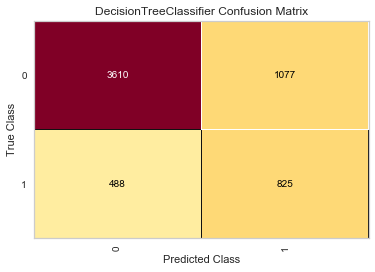

In [8]:
evf.scores_confusion_matrix(dt_gs, X_train, X_test, y_train, y_test)

## Random Forest

In [12]:
ccd_rf_clf_gs = RandomForestClassifier(n_estimators=100)

In [13]:
ccd_rf_gs_params = {
    'class_weight':['balanced', {0:1, 1:100}, {0:1, 1:50}, {0:1, 1:75}],
    'min_samples_leaf':[15, 20, 25],
    'min_samples_split':[40, 50, 70]
}
ccd_rf_gs = GridSearchCV(ccd_rf_clf_gs, ccd_rf_gs_params, cv=3, scoring='f1', n_jobs=-1)

In [14]:
ccd_rf_gs.fit(X_train, y_train);

Training Scores:
f-1 score: 0.5968577636637138
recall: 0.6708622956979147
precision:0.53755833207888
Test Scores:
f-1 score: 0.5558601782042496
recall: 0.6176694592536177
precision:0.5052959501557632


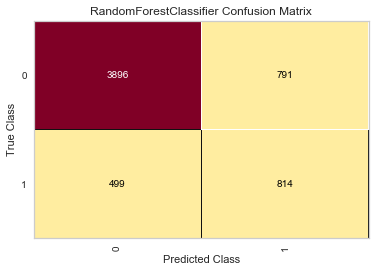

In [15]:
evf.scores_confusion_matrix(ccd_rf_gs, X_train, X_test, y_train, y_test)

## XGBoost

In [138]:
ccd_xgb = xgb.XGBClassifier(objective='binary:hinge')

In [139]:
xgb_gs_params = {
    'max_depth':[5, 6, 7, 8, 10]
}

xgb_gs = GridSearchCV(ccd_xgb, xgb_gs_params, scoring='f1', n_jobs=-1, cv=3)

In [140]:
xgb_gs.fit(X_train, y_train);

In [186]:
y_preds_xgb = xgb_gs.predict(X_test)
evf.scores_confusion_matrix(xgb_gs, X_train, X_test, y_train, y_test)


0.4772170504654581

In [53]:
dtrain = xgb.DMatrix(X_train, label=np.array(y_train))
dtest = xgb.DMatrix(X_test, label=np.array(y_test))

In [54]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric':['error', 'auc'],
    'max_depth': 7
}

In [55]:
ccd_xgb = xgb.train(xgb_params, dtrain=dtrain, evals=[(dtest, 'Test')], num_boost_round=11)

[0]	Test-error:0.179333	Test-auc:0.764051
[1]	Test-error:0.177833	Test-auc:0.7729
[2]	Test-error:0.176833	Test-auc:0.77637
[3]	Test-error:0.174333	Test-auc:0.778051
[4]	Test-error:0.175667	Test-auc:0.78111
[5]	Test-error:0.174833	Test-auc:0.782198
[6]	Test-error:0.1765	Test-auc:0.783219
[7]	Test-error:0.176167	Test-auc:0.783143
[8]	Test-error:0.1755	Test-auc:0.783738
[9]	Test-error:0.176833	Test-auc:0.784598
[10]	Test-error:0.1765	Test-auc:0.78455


In [56]:
xgb_preds = (ccd_xgb.predict(dtest) >=0.5).astype(int)
evf.all_scores(y_test, xgb_preds)

f-1 score: 0.4686402408429503
recall: 0.3556740289413557
precision:0.6867647058823529


In [171]:
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, ccd_xgb.predict(dtest))

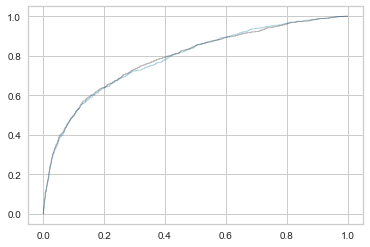

In [174]:
plt.plot(xgb_fpr, xgb_tpr, lw=1, alpha=0.3)
plt.plot(rf_fpr, rf_tpr, lw=1, alpha=0.3, color='k')

## Logistic Regression

In [24]:
ccd_lr = LogisticRegression(solver='liblinear', C=10)

In [25]:
ccd_lr.fit(X_train, y_train);

In [26]:
y_preds_lr = ccd_lr.predict(X_test)
recall_score(y_test, y_preds_lr)

0.0

In [27]:
ccd_lr.score(X_test, y_test)

0.781

# Upsampling, Downsampling, SMOTE

## Upsampling

In [19]:
X_ups, X_ups_test, y_ups, y_ups_test = evf.upsample(ccd_df, 'DEFAULT')

In [20]:
ccd_ups_rf_rs_clf = RandomForestClassifier(n_estimators=100)

ccd_ups_rf_rs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [10, 20, 30, 40]
}

ccd_ups_rf_rs = GridSearchCV(ccd_ups_rf_rs_clf, ccd_ups_rf_rs_params, scoring='recall', cv=3)

In [21]:
ccd_ups_rf_rs.fit(X_ups, y_ups);

In [ ]:
evf.scores_confusion_matrix(ccd_ups_rf_rs, X_tr_train_downs,
                      X_tr_test_downs, y_tr_train_downs, y_tr_test_downs)

## Downsampling

In [23]:
X_train_downs, X_test_downs, y_train_downs, y_test_downs = evf.undersample(ccd_df, 'DEFAULT')

In [38]:
ccd_rf_downs_clf = RandomForestClassifier(n_estimators=100)

ccd_rf_downs_rs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': sp_randint(5, 20),
    'min_samples_split': sp_randint(5, 50),
    'max_depth': sp_randint(3, 15)
}

ccd_rf_downs_rs = RandomizedSearchCV(
    ccd_tr_rf_downs_clf, ccd_tr_rf_downs_rs_params, n_iter=100, n_jobs=-1, scoring='f1', cv=3)

In [39]:
ccd_rf_downs_rs.fit(X_train_downs, y_train_downs);

Training Scores:
f-1 score: 0.7359237090392614
recall: 0.685633270321361
precision:0.7941756076198817
Test Scores:
f-1 score: 0.6757954087797019
recall: 0.6233283803863299
precision:0.7379067722075637


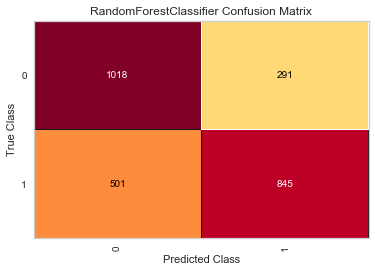

In [40]:
evf.scores_confusion_matrix(ccd_rf_downs_rs, X_train_downs, X_test_downs, y_train_downs, y_test_downs)

## SMOTE

In [9]:
ccd_smote = SMOTE()

X = ccd_df.drop('DEFAULT', axis=1)
y = ccd_df.DEFAULT

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.2)
X_sm, y_sm = ccd_smote.fit_resample(X_train_sm, y_train_sm)

In [11]:
ccd_sm_rf_rs_clf = RandomForestClassifier(n_estimators=100)

ccd_sm_rf_rs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': sp_randint(5, 20),
    'min_samples_split': sp_randint(5, 50),
    'max_depth': sp_randint(3, 15)
}


ccd_sm_rf_rs = RandomizedSearchCV(ccd_sm_rf_rs_clf, ccd_sm_rf_rs_params, scoring='recall', cv=3)

In [12]:
ccd_sm_rf_rs.fit(X_sm, y_sm);

Training Scores:
f-1 score: 0.5780081577158396
recall: 0.6362956033676334
precision:0.5295033473454772
Test Scores:
f-1 score: 0.5550630753494715
recall: 0.6305189775367932
precision:0.49573690621193667


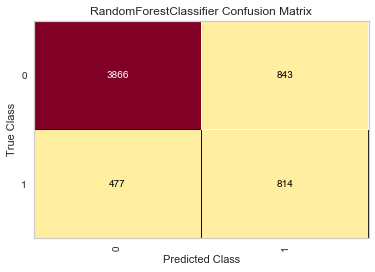

In [13]:
evf.scores_confusion_matrix(ccd_sm_rf_rs, X_train_sm, X_test_sm, y_train_sm, y_test_sm )

# Fully transformed data

In [16]:
cd.change_to_data_dir()
ccd_tr = pd.read_csv("processed/transformed_credit_card_default.csv")
cd.change_to_notebook_dir()

In [17]:
X_tr = ccd_tr.drop('DEFAULT', axis=1)
y_tr = ccd_tr.DEFAULT
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(
    X_tr, y_tr, test_size=0.2)

## Decision Trees

In [28]:
ccd_tr_dt_clf = DecisionTreeClassifier()

ccd_tr_dt_rs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': sp_randint(5, 20),
    'min_samples_split': sp_randint(5, 50),
    'max_depth': sp_randint(3, 15)
}

ccd_tr_dt_rs = RandomizedSearchCV(ccd_tr_dt_clf, ccd_tr_dt_rs_params, cv=3, scoring='recall', n_jobs=-1, n_iter=100)

In [29]:
ccd_tr_dt_rs.fit(X_tr_train, y_tr_train);

Training Scores:
f-1 score: 0.7358992026774288
recall: 0.7028958254983076
precision:0.7721545135302623
Test Scores:
f-1 score: 0.6682389937106918
recall: 0.644916540212443
precision:0.6933115823817292


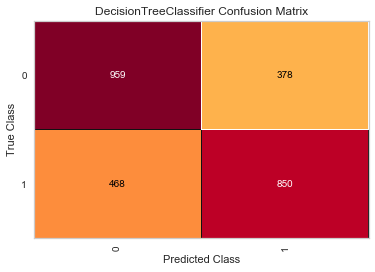

In [30]:
evf.scores_confusion_matrix(ccd_tr_dt_rs, X_tr_train_downs,
                      X_tr_test_downs, y_tr_train_downs, y_tr_test_downs)

## Random Forest

In [48]:
ccd_tr_rf_clf = RandomForestClassifier(n_estimators=100)

ccd_tr_rf_rs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': sp_randint(5, 20),
    'min_samples_split': sp_randint(5, 50),
    'max_depth': sp_randint(3, 15)
}

ccd_tr_rf_rs = RandomizedSearchCV(ccd_tr_rf_clf, ccd_tr_rf_rs_params, cv=3, scoring='f1', n_jobs=-1)

In [49]:
ccd_tr_rf_rs.fit(X_tr_train, y_tr_train);

Training Scores:
f-1 score: 0.7368526897938663
recall: 0.6905390124387486
precision:0.7898253934037508
Test Scores:
f-1 score: 0.6821705426356589
recall: 0.6285714285714286
precision:0.7457627118644068


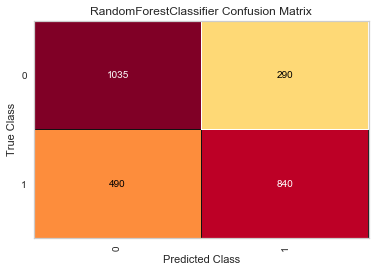

In [50]:
evf.scores_confusion_matrix(ccd_tr_rf_rs, X_tr_train_downs,
                      X_tr_test_downs, y_tr_train_downs, y_tr_test_downs)

## Undersampled Data

In [18]:
X_tr_train_downs, X_tr_test_downs, y_tr_train_downs, y_tr_test_downs = evf.undersample(ccd_tr, 'DEFAULT')

In [19]:
ccd_tr_rf_downs_clf = RandomForestClassifier(n_estimators=100)

ccd_tr_rf_downs_rs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': sp_randint(5, 20),
    'min_samples_split': sp_randint(5, 50),
    'max_depth': sp_randint(3, 15)
}

ccd_tr_rf_downs_rs = RandomizedSearchCV(
    ccd_tr_rf_downs_clf, ccd_tr_rf_downs_rs_params, n_iter=100, n_jobs=-1, scoring='recall', cv=3)

In [20]:
ccd_tr_rf_downs_rs.fit(X_tr_train_downs, y_tr_train_downs);

Training Scores:
f-1 score: 0.7616438356164383
recall: 0.705716434749906
precision:0.8271985893762398
Test Scores:
f-1 score: 0.6937269372693726
recall: 0.6418816388467374
precision:0.7546833184656556


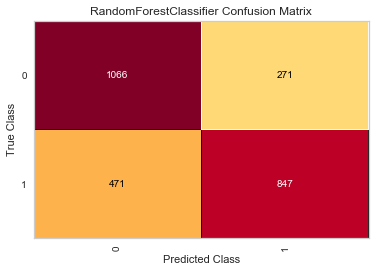

In [21]:
evf.scores_confusion_matrix(ccd_tr_rf_downs_rs, X_tr_train_downs,
                      X_tr_test_downs, y_tr_train_downs, y_tr_test_downs)

## Upsampled Data

In [33]:
X_tr_train_ups, X_tr_test_ups, y_tr_train_ups, y_tr_test_ups = evf.upsample(ccd_tr, 'DEFAULT')

In [34]:
ccd_tr_rf_ups_clf = RandomForestClassifier(n_estimators=100)

ccd_tr_rf_ups_rs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': sp_randint(5, 20),
    'min_samples_split': sp_randint(5, 50),
    'max_depth': sp_randint(3, 15)
}

ccd_tr_rf_ups_rs = RandomizedSearchCV(
    ccd_tr_rf_ups_clf, ccd_tr_rf_ups_rs_params, n_iter=100, n_jobs=-1, scoring='f1', cv=3 )

In [36]:
ccd_tr_rf_ups_rs.fit(X_tr_train_ups, y_tr_train_ups);

Training Scores:
f-1 score: 0.8144859944371085
recall: 0.7755069284682468
precision:0.8575908176547155
Test Scores:
f-1 score: 0.5427065026362039
recall: 0.5813253012048193
precision:0.5088991430454846


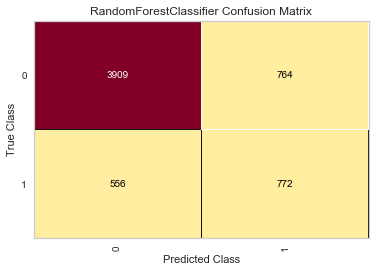

In [37]:
evf.scores_confusion_matrix(ccd_tr_rf_ups_rs, X_tr_train_ups,
                        X_tr_test_ups, y_tr_train_ups, y_tr_test_ups)

# SVM with PCA data

In [46]:
ccd_pca = PCA(n_components=10)


In [47]:
ccd_tr_pca = ccd_pca.fit_transform(X_tr_train)
ccd_tr_pca_test = ccd_pca.transform(X_tr_test)

In [48]:
ccd_svm = SVC(gamma='auto')

In [49]:
ccd_svm.fit(ccd_tr_pca, y_tr_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
svm_preds = ccd_svm.predict(ccd_tr_pca_test)

In [51]:
evf.all_scores(y_tr_test, svm_preds)

f-1 score: 0.04657534246575343
recall: 0.025411061285500747
precision:0.2786885245901639
